# **TEXT MINING PROJECT**: 20 NEWS GROUP CLASSIFICATION  

Antonella Zaccaria  
Marco Savino

**Pipeline**

![picture](https://drive.google.com/uc?id=1nAJkGnNtoIbfOo7XdpTtSdep1bfyAavD)

Librerie utilizzate

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('punkt') #serve per la tokenizzazione
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

Carichiamo il dataset 20 News Group direttamente dal **sklearn** e lo salviamo in formato csv

In [3]:
def twenty_newsgroup_to_csv():
    newsgroups = fetch_20newsgroups(subset = 'all', shuffle=True)

    df = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
    df.columns = ['text', 'target']
    targets = pd.DataFrame(newsgroups.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_news.csv')
    
  
twenty_newsgroup_to_csv()

In [0]:
df = pd.read_csv('20_news.csv')

Visualizziamo le prime righe del dataset

In [5]:
df.head()

,Unnamed: 0,text,target,title
0,0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,8,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,24,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,44,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


Eliminiamo la colonna **Unnamed: 0**

In [0]:
df = df.drop('Unnamed: 0', 1)

In [7]:
df.head()

,text,target,title
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


## **Data esploration**

Dimensione del dataset

In [8]:
df.shape

(18846, 3)

Controlliamo se sono presenti **na**

In [9]:
df.isnull().sum()

text      0
target    0
title     0
dtype: int64

Lista target

In [10]:
print(df.title.unique())

['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


In [11]:
print(df.target.unique())

[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]


Controlliamo se le categorie (target) sono bilanciate

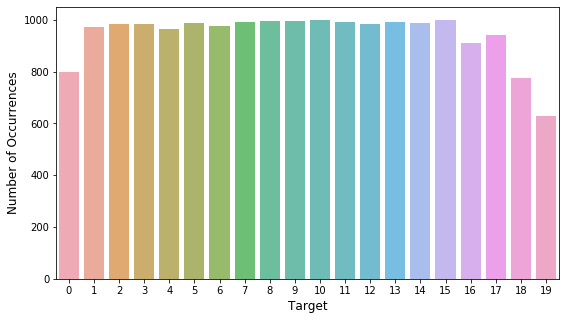

In [12]:
count_target = df['target'].value_counts()

plt.figure(figsize=(9,5))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

## **Preprocessing**

Per le operazioni di preprocessing creiamo una nuova colonna del DataFrame df chiamata **text_processed**, mantenendo la colonna del testo originale

**1.** Conversione del testo in minuscolo

In [0]:
df['text_processed'] = df['text'].map(lambda x: x.lower())

**2.** Eliminazione indirizzi mail

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\S*@\S*\s?',' ', x))

**3.** Eliminazione numeri

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\d+',' ', x))

**4.** Eliminazione caratteri di punteggiatura

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'[^\w]', ' ', x))

**5.** Rimozione parole composta da 1 e due lettere

In [0]:
df['text_processed'] = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

**6.** Sistemazione degli spazi che si sono creati con le precedenti operazioni

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) #rimozione spazi di inizio riga

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) #rimozione spazi di fine riga

**7.** Tokenizzazione

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: nltk.word_tokenize(x))

**8.** Rimozione Stopwords

In [0]:
#lista stop_words
en_stopwords = stopwords.words ('english')

In [23]:
#numero di stopwords
len(en_stopwords)

179

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: [item for item in x if item not in en_stopwords])

Per effettuare le operazioni di lemmatizzazione e stemming verranno create quattro nuove colonne (rispettivamente **text_processed_lem**,  **text_processed_stem_porter**, **text_processed_stem_snowball** e **text_processed_stem_lancaster**) in modo da tenere separate le operazioni di lem e stem

**9.** Lemmatizzazione  

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
df['text_processed_lem'] = df['text_processed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

**10.** Stemming

**10.1** Porter Stemmer

In [0]:
ps = PorterStemmer()

In [0]:
df['text_processed_stem_porter'] = df['text_processed'].apply(lambda x: [ps.stem(y) for y in x])

**10.2** Snowball Stemmer

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
ss = SnowballStemmer("english")

In [0]:
df['text_processed_stem_snowball'] = df['text_processed'].apply(lambda x: [ss.stem(y) for y in x])

**10.3** Lancaster Stemmer

In [0]:
from nltk.stem import LancasterStemmer

In [0]:
ls = LancasterStemmer()

In [0]:
df['text_processed_stem_lancaster'] = df['text_processed'].apply(lambda x: [ls.stem(y) for y in x])

Teminata la fase di preprocessing del testo suddividiamo il Dataset in **train set (70%)** e **test set (30%)** in modo da poter addestrare e testare il classificatore  

**train_lem_x**: train set  di text_processed_lem  
**train_lem_y**: target train set di text_processed_lem  
**test_lem_x**: test set di text_processed_lem   
**test_lem_y**: target test di text_processed_lem 

**train_stem_porter_x**: train set  di text_processed_stem_porter  
**train_stem_porter_y**: target train set di text_processed_stem_porter    
**test_stem_porter_x**: test set di text_processed_stem_porter     
**test_stem_porter_y**: target test di text_processed_stem_porter  

**train_stem_snowball_x**: train set  di text_processed_stem_snowball  
**train_stem_porter_snowball_y**: target train set di text_processed_stem_snowball      
**test_stem_porter_snowball_x**: test set di text_processed_stem_snowball       
**test_stem_porter_snowball_y**: target test di text_processed_stem_snowball  

**train_stem_lancaster_x**: train set  di text_processed_stem_lancaster    
**train_stem_porter_lancaster_y**: target train set di text_processed_stem_lancaster        
**test_stem_porter_lancaster_x**: test set di text_processed_stem_lancaster         
**test_stem_porter_lancaster_y**: target test di text_processed_stem_lancaster  


In [0]:
train_lem_x, test_lem_x, train_lem_y, test_lem_y = model_selection.train_test_split(df['text_processed_lem'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_porter_x, test_stem_porter_x, train_stem_porter_y, test_stem_porter_y = model_selection.train_test_split(df['text_processed_stem_porter'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_snowball_x, test_stem_snowball_x, train_stem_snowball_y, test_stem_snowball_y = model_selection.train_test_split(df['text_processed_stem_snowball'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_lancaster_x, test_stem_lancaster_x, train_stem_lancaster_y, test_stem_lancaster_y = model_selection.train_test_split(df['text_processed_stem_lancaster'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [39]:
print('La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è', len(train_lem_x))
print('La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è', len(test_lem_x))

print('La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è', len(train_stem_porter_x))
print('La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è', len(test_stem_porter_x))

print('La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è', len(train_stem_snowball_x))
print('La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è', len(test_stem_snowball_x))

print('La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è', len(train_stem_lancaster_x))
print('La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è', len(test_stem_lancaster_x))


La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è 13192
La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è 5654


## **Feature Engineering**  
In questa fase creiamo le strutture **tf** e **tf-idf** che saranno poi utilizzate dagli algoritmi di Machine Learning per effettuare la classificazione

**Term Frequency**

In [0]:
count_vect = CountVectorizer(analyzer='word')

I successivi otto passaggi servono per adeguare il formato alla funzione di creazione delle matrici tf e tf-idf

In [0]:
a = train_lem_x.astype(str)

In [0]:
b = test_lem_x.astype(str)

In [0]:
c = train_stem_porter_x.astype(str)

In [0]:
d = test_stem_porter_x.astype(str)

In [0]:
e = train_stem_snowball_x.astype(str)

In [0]:
f = test_stem_snowball_x.astype(str)

In [0]:
g = train_stem_lancaster_x.astype(str)

In [0]:
h = test_stem_lancaster_x.astype(str)

Creazione matrice tf per train_lem_x

In [49]:
tf_train_lem_x = count_vect.fit_transform(a)
tf_train_lem_x

<13192x78462 sparse matrix of type '<class 'numpy.int64'>'
	with 1315155 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_lem_x

In [50]:
tf_test_lem_x = count_vect.transform(b)
tf_test_lem_x

<5654x78462 sparse matrix of type '<class 'numpy.int64'>'
	with 549716 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_porter_x

In [51]:
tf_train_stem_porter_x = count_vect.fit_transform(c)
tf_train_stem_porter_x

<13192x64774 sparse matrix of type '<class 'numpy.int64'>'
	with 1271165 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_porter_x

In [52]:
tf_test_stem_porter_x = count_vect.transform(d)
tf_test_stem_porter_x

<5654x64774 sparse matrix of type '<class 'numpy.int64'>'
	with 534196 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_snowball_x

In [53]:
tf_train_stem_snowball_x = count_vect.fit_transform(e)
tf_train_stem_snowball_x

<13192x64592 sparse matrix of type '<class 'numpy.int64'>'
	with 1270062 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_snowball_x

In [54]:
tf_test_stem_snowball_x = count_vect.transform(f)
tf_test_stem_snowball_x

<5654x64592 sparse matrix of type '<class 'numpy.int64'>'
	with 533743 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_lancaster_x

In [55]:
tf_train_stem_lancaster_x = count_vect.fit_transform(g)
tf_train_stem_lancaster_x

<13192x55921 sparse matrix of type '<class 'numpy.int64'>'
	with 1246743 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_lancaster_x

In [56]:
tf_test_stem_lancaster_x = count_vect.transform(h)
tf_test_stem_lancaster_x

<5654x55921 sparse matrix of type '<class 'numpy.int64'>'
	with 526015 stored elements in Compressed Sparse Row format>

**TF-IDF unigram** 

In [0]:
tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1,1))

Creazione matrice tf-idf per train_lem_x

In [0]:
tfidf.fit(a)
tfidf_train_lem_x =  tfidf.transform(a)

In [59]:
tfidf_train_lem_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1218276 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_lem_x

In [0]:
tfidf_test_lem_x =  tfidf.transform(b)

In [61]:
tfidf_test_lem_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 518723 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_porter_x

In [0]:
tfidf.fit(c)
tfidf_train_stem_porter_x =  tfidf.transform(c)

In [63]:
tfidf_train_stem_porter_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1207309 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_porter_x

In [0]:
tfidf_test_stem_porter_x =  tfidf.transform(d)

In [65]:
tfidf_test_stem_porter_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 514858 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_snowball_x

In [0]:
tfidf.fit(e)
tfidf_train_stem_snowball_x =  tfidf.transform(e)

In [67]:
tfidf_train_stem_snowball_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1206779 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_snowball_x

In [0]:
tfidf_test_stem_snowball_x =  tfidf.transform(f)

In [69]:
tfidf_test_stem_snowball_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 514716 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_lancaster_x

In [0]:
tfidf.fit(g)
tfidf_train_stem_lancaster_x =  tfidf.transform(g)

In [71]:
tfidf_train_stem_lancaster_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1200364 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_lancaster_x

In [0]:
tfidf_test_stem_lancaster_x =  tfidf.transform(h)

In [73]:
tfidf_test_stem_lancaster_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 512618 stored elements in Compressed Sparse Row format>

**TF-IDF unigram + bigram** 

In [0]:
bi_tfidf = TfidfVectorizer(max_features=20000, analyzer='word',ngram_range=(1,2))

Creazione matrice tf-idf bigram per train_lem_x

In [0]:
bi_tfidf.fit(a)
bi_train_lem_x =  bi_tfidf.transform(a)

In [76]:
bi_train_lem_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1412473 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_lem_x

In [0]:
bi_test_lem_x =  bi_tfidf.transform(b)

In [78]:
bi_test_lem_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 599015 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_porter_x

In [0]:
bi_tfidf.fit(c)
bi_train_stem_porter_x =  bi_tfidf.transform(c)

In [80]:
bi_train_stem_porter_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1436664 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_porter_x

In [0]:
bi_test_stem_porter_x =  bi_tfidf.transform(d)

In [82]:
bi_test_stem_porter_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 609766 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_snowball_x

In [0]:
bi_tfidf.fit(e)
bi_train_stem_snowball_x =  bi_tfidf.transform(e)

In [84]:
bi_train_stem_snowball_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1437166 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_snowball_x

In [0]:
bi_test_stem_snowball_x =  bi_tfidf.transform(f)

In [86]:
bi_test_stem_snowball_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 610066 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_lancaster_x

In [0]:
bi_tfidf.fit(g)
bi_train_stem_lancaster_x = bi_tfidf.transform(g)

In [88]:
bi_train_stem_lancaster_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1456649 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_lancaster_x

In [0]:
bi_test_stem_lancaster_x = bi_tfidf.transform(h)

In [90]:
bi_test_stem_lancaster_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 618408 stored elements in Compressed Sparse Row format>

## **Classification**

### **1. Naive Bayes**

In [0]:
clf = MultinomialNB()

**1.1 Naive Bayes con TF + Lemmatization**

Cross Validation (train set)

In [92]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=3)

CPU times: user 257 ms, sys: 4.96 ms, total: 262 ms
Wall time: 262 ms


In [93]:
print(score)
print(score.mean())

[0.85493406 0.86399818 0.85171708]
0.8568831071138704


Previsione su dati mai visti (test set)

In [94]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       267
           1       0.70      0.90      0.79       269
           2       0.93      0.65      0.77       294
           3       0.76      0.82      0.78       299
           4       0.83      0.92      0.87       267
           5       0.83      0.86      0.85       309
           6       0.91      0.82      0.86       275
           7       0.91      0.91      0.91       299
           8       0.95      0.95      0.95       293
           9       0.98      0.96      0.97       313
          10       0.96      0.96      0.96       295
          11       0.92      0.95      0.94       301
          12       0.90      0.81      0.85       302
          13       0.96      0.95      0.95       288
          14       0.96      0.95      0.96       300
          15       0.86      0.92      0.89       302
          16       0.80      0.94      0.87       282
          17       0.97    

**1.2 Naive Bayes con TF + Stemming (Porter)**

Cross Validation (train set)

In [95]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 247 ms, sys: 2.98 ms, total: 250 ms
Wall time: 249 ms


In [96]:
print(score)
print(score.mean())

[0.84993179 0.86104162 0.84603139]
0.8523349304990391


Previsione su dati mai visti (test set)

In [97]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       267
           1       0.69      0.87      0.77       269
           2       0.92      0.61      0.73       294
           3       0.73      0.81      0.77       299
           4       0.82      0.93      0.87       267
           5       0.83      0.84      0.84       309
           6       0.90      0.78      0.83       275
           7       0.91      0.90      0.90       299
           8       0.94      0.94      0.94       293
           9       0.97      0.96      0.96       313
          10       0.96      0.96      0.96       295
          11       0.90      0.95      0.93       301
          12       0.86      0.80      0.83       302
          13       0.97      0.96      0.96       288
          14       0.96      0.95      0.95       300
          15       0.86      0.92      0.89       302
          16       0.80      0.93      0.86       282
          17       0.96    

**1.3 Naive Bayes con TF + Stemming (Snowball)**

Cross Validation (train set)

In [98]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 256 ms, sys: 4.01 ms, total: 260 ms
Wall time: 260 ms


In [99]:
print(score)
print(score.mean())

[0.84947704 0.86149647 0.8469411 ]
0.8526382020290337


Previsione su dati mai visti (test set)

In [100]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       267
           1       0.68      0.88      0.77       269
           2       0.92      0.60      0.73       294
           3       0.74      0.82      0.77       299
           4       0.81      0.93      0.87       267
           5       0.84      0.84      0.84       309
           6       0.90      0.79      0.84       275
           7       0.91      0.90      0.91       299
           8       0.94      0.94      0.94       293
           9       0.97      0.95      0.96       313
          10       0.96      0.96      0.96       295
          11       0.90      0.95      0.93       301
          12       0.86      0.80      0.83       302
          13       0.97      0.96      0.97       288
          14       0.96      0.95      0.95       300
          15       0.86      0.92      0.89       302
          16       0.80      0.94      0.87       282
          17       0.96    

**1.4 Naive Bayes con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [101]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 197 ms, sys: 5.96 ms, total: 203 ms
Wall time: 203 ms


In [102]:
print(score)
print(score.mean())

[0.84038199 0.84967023 0.84034569]
0.8434659705866262


Previsione su dati mai visti (test set)

In [103]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       267
           1       0.67      0.87      0.76       269
           2       0.93      0.57      0.71       294
           3       0.72      0.82      0.76       299
           4       0.82      0.91      0.86       267
           5       0.84      0.84      0.84       309
           6       0.89      0.76      0.82       275
           7       0.91      0.89      0.90       299
           8       0.94      0.94      0.94       293
           9       0.97      0.95      0.96       313
          10       0.96      0.96      0.96       295
          11       0.91      0.94      0.92       301
          12       0.85      0.79      0.82       302
          13       0.96      0.96      0.96       288
          14       0.95      0.94      0.94       300
          15       0.85      0.92      0.89       302
          16       0.79      0.93      0.85       282
          17       0.96    

**1.5 Naive Bayes con TF-IDF + Lemmatization**

Cross Validation (train set)

In [104]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=3)

CPU times: user 148 ms, sys: 995 µs, total: 149 ms
Wall time: 148 ms


In [105]:
print(score)
print(score.mean())

[0.85288768 0.86286104 0.85444621]
0.8567316437210054


Previsione su dati mai visti (test set)

In [106]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       267
           1       0.76      0.87      0.81       269
           2       0.84      0.83      0.83       294
           3       0.78      0.82      0.80       299
           4       0.84      0.91      0.87       267
           5       0.91      0.86      0.88       309
           6       0.88      0.85      0.87       275
           7       0.92      0.90      0.91       299
           8       0.95      0.97      0.96       293
           9       0.97      0.95      0.96       313
          10       0.96      0.97      0.97       295
          11       0.91      0.96      0.94       301
          12       0.91      0.82      0.86       302
          13       0.95      0.95      0.95       288
          14       0.96      0.95      0.96       300
          15       0.70      0.95      0.80       302
          16       0.78      0.98      0.87       282
          17       0.95    

**1.6 Naive Bayes con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [107]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 146 ms, sys: 1 ms, total: 147 ms
Wall time: 146 ms


In [108]:
print(score)
print(score.mean())

[0.84834015 0.8576302  0.84898795]
0.8516527677845035


Previsione su dati mai visti (test set)

In [109]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       267
           1       0.74      0.85      0.79       269
           2       0.84      0.83      0.83       294
           3       0.78      0.81      0.80       299
           4       0.85      0.91      0.88       267
           5       0.92      0.85      0.88       309
           6       0.88      0.84      0.86       275
           7       0.93      0.90      0.92       299
           8       0.94      0.97      0.95       293
           9       0.97      0.95      0.96       313
          10       0.96      0.98      0.97       295
          11       0.88      0.97      0.92       301
          12       0.90      0.80      0.85       302
          13       0.95      0.94      0.95       288
          14       0.96      0.95      0.96       300
          15       0.68      0.95      0.79       302
          16       0.75      0.97      0.85       282
          17       0.95    

**1.7 Naive Bayes con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [110]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 142 ms, sys: 979 µs, total: 143 ms
Wall time: 142 ms


In [111]:
print(score)
print(score.mean())

[0.84765803 0.85717535 0.84967023]
0.851501200968359


Previsione su dati mai visti (test set)

In [112]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       267
           1       0.75      0.85      0.79       269
           2       0.85      0.83      0.84       294
           3       0.78      0.81      0.80       299
           4       0.85      0.91      0.88       267
           5       0.92      0.85      0.88       309
           6       0.88      0.84      0.86       275
           7       0.93      0.90      0.91       299
           8       0.94      0.97      0.95       293
           9       0.97      0.96      0.96       313
          10       0.97      0.98      0.97       295
          11       0.88      0.97      0.92       301
          12       0.90      0.80      0.84       302
          13       0.95      0.95      0.95       288
          14       0.95      0.95      0.95       300
          15       0.67      0.95      0.79       302
          16       0.76      0.98      0.85       282
          17       0.95    

**1.8 Naive Bayes con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [113]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 139 ms, sys: 1.99 ms, total: 141 ms
Wall time: 140 ms


In [114]:
print(score)
print(score.mean())

[0.8431105  0.8510348  0.84603139]
0.8467255620874251


Previsione su dati mai visti (test set)

In [115]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       267
           1       0.75      0.84      0.79       269
           2       0.84      0.81      0.82       294
           3       0.74      0.81      0.78       299
           4       0.85      0.91      0.88       267
           5       0.93      0.83      0.88       309
           6       0.89      0.85      0.87       275
           7       0.92      0.89      0.91       299
           8       0.94      0.97      0.95       293
           9       0.97      0.96      0.96       313
          10       0.97      0.98      0.98       295
          11       0.88      0.97      0.92       301
          12       0.88      0.78      0.83       302
          13       0.95      0.93      0.94       288
          14       0.94      0.96      0.95       300
          15       0.65      0.95      0.78       302
          16       0.74      0.98      0.84       282
          17       0.95    

**1.9 Naive Bayes con Bigram + Lemmatization**

Cross Validation (train set)

In [116]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=3)

CPU times: user 172 ms, sys: 1.99 ms, total: 174 ms
Wall time: 173 ms


In [117]:
print(score)
print(score.mean())

[0.86243747 0.86809188 0.8576302 ]
0.8627198516055206


Previsione su dati mai visti (test set)

In [118]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84       267
           1       0.73      0.88      0.80       269
           2       0.84      0.83      0.83       294
           3       0.78      0.79      0.79       299
           4       0.83      0.89      0.86       267
           5       0.91      0.87      0.89       309
           6       0.82      0.88      0.85       275
           7       0.91      0.90      0.90       299
           8       0.93      0.95      0.94       293
           9       0.95      0.94      0.94       313
          10       0.95      0.97      0.96       295
          11       0.96      0.95      0.95       301
          12       0.90      0.80      0.85       302
          13       0.93      0.94      0.94       288
          14       0.94      0.94      0.94       300
          15       0.73      0.94      0.82       302
          16       0.80      0.95      0.87       282
          17       0.96    

**1.10 Naive Bayes con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [119]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 162 ms, sys: 1.99 ms, total: 164 ms
Wall time: 166 ms


In [120]:
print(score)
print(score.mean())

[0.86198272 0.86763703 0.85285422]
0.8608246544826459


Previsione su dati mai visti (test set)

In [121]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       267
           1       0.73      0.86      0.79       269
           2       0.84      0.82      0.83       294
           3       0.77      0.79      0.78       299
           4       0.84      0.90      0.87       267
           5       0.90      0.88      0.89       309
           6       0.83      0.87      0.85       275
           7       0.92      0.91      0.92       299
           8       0.94      0.94      0.94       293
           9       0.95      0.94      0.94       313
          10       0.95      0.98      0.96       295
          11       0.95      0.95      0.95       301
          12       0.89      0.79      0.84       302
          13       0.94      0.94      0.94       288
          14       0.95      0.94      0.94       300
          15       0.72      0.95      0.82       302
          16       0.79      0.95      0.86       282
          17       0.97    

**1.11 Naive Bayes con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [122]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 160 ms, sys: 2.98 ms, total: 163 ms
Wall time: 167 ms


In [123]:
print(score)
print(score.mean())

[0.86061846 0.86763703 0.8535365 ]
0.8605973301142492


Previsione su dati mai visti (test set)

In [124]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       267
           1       0.73      0.86      0.79       269
           2       0.84      0.82      0.83       294
           3       0.77      0.79      0.78       299
           4       0.84      0.89      0.87       267
           5       0.90      0.87      0.89       309
           6       0.84      0.87      0.85       275
           7       0.92      0.91      0.92       299
           8       0.94      0.95      0.95       293
           9       0.95      0.94      0.94       313
          10       0.95      0.98      0.96       295
          11       0.94      0.95      0.95       301
          12       0.89      0.80      0.84       302
          13       0.94      0.94      0.94       288
          14       0.95      0.94      0.94       300
          15       0.72      0.95      0.82       302
          16       0.79      0.95      0.86       282
          17       0.97    

**1.12 Naive Bayes con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [125]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 174 ms, sys: 1.01 ms, total: 175 ms
Wall time: 177 ms


In [126]:
print(score)
print(score.mean())

[0.85288768 0.86217876 0.84989766]
0.8549880306514884


Previsione su dati mai visti (test set)

In [127]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       267
           1       0.72      0.85      0.78       269
           2       0.85      0.81      0.83       294
           3       0.76      0.79      0.77       299
           4       0.83      0.88      0.86       267
           5       0.91      0.87      0.89       309
           6       0.84      0.87      0.85       275
           7       0.91      0.91      0.91       299
           8       0.95      0.95      0.95       293
           9       0.95      0.94      0.95       313
          10       0.96      0.98      0.97       295
          11       0.95      0.95      0.95       301
          12       0.88      0.81      0.84       302
          13       0.92      0.93      0.93       288
          14       0.94      0.94      0.94       300
          15       0.71      0.95      0.81       302
          16       0.80      0.96      0.87       282
          17       0.96    

### **2. Support Vector Machine (SVM)**

In [0]:
clf = svm.SVC()

**2.1 SVM con TF + Lemmatization**

Cross Validation (train set)

In [130]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=3)

CPU times: user 5min 48s, sys: 96 ms, total: 5min 48s
Wall time: 5min 48s


In [131]:
print(score)
print(score.mean())

[0.74988631 0.74459859 0.75460541]
0.7496967715630385


Previsione su dati mai visti (test set)

In [132]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81       267
           1       0.47      0.84      0.60       269
           2       0.80      0.67      0.73       294
           3       0.79      0.70      0.74       299
           4       0.89      0.82      0.85       267
           5       0.87      0.72      0.79       309
           6       0.63      0.89      0.74       275
           7       0.91      0.83      0.87       299
           8       0.95      0.87      0.91       293
           9       0.90      0.88      0.89       313
          10       1.00      0.84      0.91       295
          11       0.98      0.84      0.91       301
          12       0.60      0.83      0.69       302
          13       0.82      0.86      0.84       288
          14       0.96      0.81      0.88       300
          15       0.83      0.87      0.85       302
          16       0.86      0.80      0.83       282
          17       0.72    

**2.2 SVM con TF + Stemming (Porter)**

Cross validation (train set)

In [133]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 5min 31s, sys: 132 ms, total: 5min 32s
Wall time: 5min 32s


In [134]:
print(score)
print(score.mean())

[0.74920418 0.74323402 0.75164885]
0.7480290194690532


Previsione su dati mai visti (test set)

In [135]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       267
           1       0.49      0.83      0.62       269
           2       0.80      0.67      0.73       294
           3       0.80      0.71      0.75       299
           4       0.91      0.81      0.86       267
           5       0.87      0.72      0.79       309
           6       0.59      0.89      0.71       275
           7       0.89      0.82      0.85       299
           8       0.95      0.88      0.91       293
           9       0.88      0.89      0.88       313
          10       1.00      0.85      0.92       295
          11       0.98      0.84      0.91       301
          12       0.63      0.82      0.72       302
          13       0.80      0.88      0.84       288
          14       0.97      0.80      0.88       300
          15       0.82      0.87      0.84       302
          16       0.85      0.79      0.82       282
          17       0.72    

**2.3 SVM con TF + Stemming (Snowball)**

Cross Validation (train set)

In [136]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 5min 29s, sys: 63 ms, total: 5min 29s
Wall time: 5min 30s


In [137]:
print(score)
print(score.mean())

[0.74874943 0.74368888 0.75187628]
0.7481048632073716


Previsione su dati mai visti (test set)

In [138]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.72      0.79       267
           1       0.49      0.83      0.61       269
           2       0.80      0.67      0.73       294
           3       0.80      0.71      0.75       299
           4       0.91      0.81      0.86       267
           5       0.88      0.72      0.79       309
           6       0.59      0.90      0.71       275
           7       0.88      0.82      0.85       299
           8       0.95      0.88      0.91       293
           9       0.88      0.89      0.88       313
          10       1.00      0.85      0.92       295
          11       0.98      0.84      0.91       301
          12       0.64      0.82      0.72       302
          13       0.80      0.88      0.84       288
          14       0.96      0.80      0.87       300
          15       0.82      0.87      0.84       302
          16       0.84      0.79      0.82       282
          17       0.72    

**2.4 SVM con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [139]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 5min 14s, sys: 40.8 ms, total: 5min 14s
Wall time: 5min 15s


In [140]:
print(score)
print(score.mean())

[0.737608   0.74095975 0.74755515]
0.7420409667194573


Previsione su dati mai visti (test set)

In [141]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.72      0.79       267
           1       0.48      0.83      0.60       269
           2       0.80      0.62      0.70       294
           3       0.75      0.71      0.73       299
           4       0.87      0.82      0.84       267
           5       0.86      0.71      0.78       309
           6       0.55      0.87      0.68       275
           7       0.85      0.82      0.83       299
           8       0.96      0.87      0.91       293
           9       0.91      0.87      0.89       313
          10       0.99      0.85      0.91       295
          11       0.98      0.82      0.89       301
          12       0.63      0.79      0.70       302
          13       0.81      0.87      0.84       288
          14       0.95      0.79      0.86       300
          15       0.82      0.86      0.84       302
          16       0.84      0.80      0.82       282
          17       0.72    

**2.5 SVM con TF-IDF + Lemmatization**

Cross Validation (train set)

In [142]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=3)

CPU times: user 7min 17s, sys: 74.9 ms, total: 7min 17s
Wall time: 7min 17s


In [143]:
print(score)
print(score.mean())

[0.88244657 0.89174437 0.88173755]
0.8853094953705843


Previsione su dati mai visti (test set)

In [144]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       267
           1       0.75      0.91      0.83       269
           2       0.86      0.83      0.84       294
           3       0.80      0.83      0.82       299
           4       0.94      0.89      0.91       267
           5       0.91      0.89      0.90       309
           6       0.85      0.91      0.88       275
           7       0.95      0.93      0.94       299
           8       0.98      0.97      0.97       293
           9       0.97      0.96      0.97       313
          10       0.99      0.96      0.98       295
          11       0.99      0.93      0.96       301
          12       0.84      0.90      0.87       302
          13       0.93      0.97      0.95       288
          14       0.98      0.94      0.96       300
          15       0.88      0.93      0.90       302
          16       0.89      0.93      0.91       282
          17       0.99    

**2.6 SVM con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [145]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 7min 12s, sys: 61 ms, total: 7min 12s
Wall time: 7min 12s


In [146]:
print(score)
print(score.mean())

[0.8792633  0.89151694 0.87878099]
0.8831870773025926


Previsione su dati mai visti (test set)

In [147]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       267
           1       0.73      0.93      0.82       269
           2       0.87      0.83      0.85       294
           3       0.81      0.83      0.82       299
           4       0.94      0.89      0.91       267
           5       0.90      0.87      0.89       309
           6       0.85      0.91      0.88       275
           7       0.95      0.92      0.94       299
           8       0.99      0.96      0.97       293
           9       0.98      0.97      0.97       313
          10       1.00      0.97      0.98       295
          11       0.98      0.93      0.95       301
          12       0.85      0.91      0.88       302
          13       0.93      0.97      0.95       288
          14       0.98      0.95      0.97       300
          15       0.89      0.93      0.91       302
          16       0.89      0.93      0.91       282
          17       0.99    

**2.7 SVM con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [148]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 7min 14s, sys: 55 ms, total: 7min 14s
Wall time: 7min 14s


In [149]:
print(score)
print(score.mean())

[0.8792633  0.89106209 0.87832613]
0.8828838402470245


Previsione su dati mai visti (test set)

In [150]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       267
           1       0.73      0.93      0.82       269
           2       0.87      0.83      0.85       294
           3       0.81      0.83      0.82       299
           4       0.94      0.88      0.91       267
           5       0.89      0.87      0.88       309
           6       0.85      0.91      0.88       275
           7       0.95      0.92      0.94       299
           8       0.99      0.96      0.97       293
           9       0.98      0.97      0.98       313
          10       1.00      0.97      0.98       295
          11       0.98      0.93      0.95       301
          12       0.85      0.91      0.88       302
          13       0.93      0.97      0.95       288
          14       0.98      0.95      0.97       300
          15       0.89      0.93      0.91       302
          16       0.89      0.93      0.91       282
          17       0.99    

**2.8 SVM con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [151]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 7min 10s, sys: 50 ms, total: 7min 10s
Wall time: 7min 10s


In [152]:
print(score)
print(score.mean())

[0.87426103 0.88810553 0.87627928]
0.879548611854466


Previsione su dati mai visti (test set)

In [153]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       267
           1       0.74      0.91      0.82       269
           2       0.86      0.80      0.83       294
           3       0.81      0.82      0.81       299
           4       0.92      0.89      0.90       267
           5       0.86      0.88      0.87       309
           6       0.85      0.90      0.87       275
           7       0.92      0.90      0.91       299
           8       0.98      0.96      0.97       293
           9       0.97      0.96      0.97       313
          10       1.00      0.97      0.98       295
          11       0.99      0.91      0.95       301
          12       0.84      0.90      0.87       302
          13       0.90      0.96      0.93       288
          14       0.98      0.94      0.96       300
          15       0.89      0.92      0.91       302
          16       0.89      0.93      0.91       282
          17       0.98    

**2.9 SVM con Bigram + Lemmatization**

Cross Validation (train set)

In [154]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=3)

CPU times: user 8min 15s, sys: 65.9 ms, total: 8min 15s
Wall time: 8min 15s


In [155]:
print(score)
print(score.mean())

[0.88153706 0.89128952 0.87923584]
0.8840208068332726


Previsione su dati mai visti (test set)

In [156]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       267
           1       0.71      0.91      0.80       269
           2       0.86      0.82      0.84       294
           3       0.80      0.82      0.81       299
           4       0.91      0.88      0.89       267
           5       0.92      0.87      0.90       309
           6       0.84      0.90      0.87       275
           7       0.95      0.90      0.93       299
           8       0.98      0.96      0.97       293
           9       0.97      0.96      0.97       313
          10       0.99      0.96      0.98       295
          11       0.99      0.93      0.96       301
          12       0.82      0.88      0.85       302
          13       0.92      0.96      0.94       288
          14       0.98      0.93      0.96       300
          15       0.90      0.94      0.92       302
          16       0.90      0.93      0.91       282
          17       0.99    

**2.10 SVM con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [157]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 8min 24s, sys: 62.9 ms, total: 8min 24s
Wall time: 8min 25s


In [158]:
print(score)
print(score.mean())

[0.88130969 0.8944735  0.87900841]
0.8849305352371905


Previsione su dati mai visti (test set)

In [159]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       267
           1       0.71      0.92      0.81       269
           2       0.87      0.83      0.85       294
           3       0.80      0.82      0.81       299
           4       0.89      0.88      0.89       267
           5       0.93      0.88      0.90       309
           6       0.84      0.90      0.87       275
           7       0.94      0.91      0.93       299
           8       0.99      0.96      0.97       293
           9       0.97      0.97      0.97       313
          10       0.99      0.96      0.98       295
          11       0.99      0.93      0.96       301
          12       0.85      0.90      0.88       302
          13       0.93      0.96      0.95       288
          14       0.98      0.93      0.96       300
          15       0.90      0.93      0.92       302
          16       0.90      0.93      0.92       282
          17       0.99    

**2.11 SVM con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [160]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 8min 24s, sys: 54 ms, total: 8min 24s
Wall time: 8min 24s


In [161]:
print(score)
print(score.mean())

[0.88085493 0.8944735  0.8796907 ]
0.8850063789755089


Previsione su dati mai visti (test set)

In [162]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       267
           1       0.72      0.93      0.81       269
           2       0.86      0.83      0.85       294
           3       0.79      0.82      0.81       299
           4       0.89      0.88      0.89       267
           5       0.93      0.88      0.90       309
           6       0.84      0.90      0.87       275
           7       0.95      0.91      0.93       299
           8       0.99      0.97      0.98       293
           9       0.97      0.97      0.97       313
          10       0.99      0.96      0.98       295
          11       0.99      0.93      0.96       301
          12       0.86      0.89      0.87       302
          13       0.93      0.96      0.95       288
          14       0.98      0.93      0.96       300
          15       0.90      0.93      0.92       302
          16       0.90      0.93      0.92       282
          17       0.99    

**2.12 SVM con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [163]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 8min 29s, sys: 55 ms, total: 8min 29s
Wall time: 8min 29s


In [164]:
print(score)
print(score.mean())

[0.87608004 0.89379122 0.88037298]
0.8834147464152543


Previsione su dati mai visti (test set)

In [165]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       267
           1       0.71      0.90      0.80       269
           2       0.87      0.81      0.84       294
           3       0.79      0.82      0.80       299
           4       0.89      0.88      0.89       267
           5       0.90      0.89      0.89       309
           6       0.85      0.90      0.87       275
           7       0.92      0.90      0.91       299
           8       0.99      0.96      0.97       293
           9       0.96      0.96      0.96       313
          10       0.99      0.96      0.97       295
          11       0.99      0.92      0.96       301
          12       0.84      0.88      0.86       302
          13       0.92      0.95      0.94       288
          14       0.98      0.93      0.96       300
          15       0.91      0.94      0.92       302
          16       0.89      0.93      0.91       282
          17       0.99    

###**3. Random Forest**

In [0]:
clf = RandomForestClassifier()

**3.1 Random Forest con TF + Lemmatization**

Cross Validation (train test)

In [168]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=3)

CPU times: user 1min 34s, sys: 119 ms, total: 1min 34s
Wall time: 1min 34s


In [169]:
print(score)
print(score.mean())

[0.82787631 0.83579713 0.82033204]
0.8280018287993774


Previsione su dati mai visti (test set)

In [170]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       267
           1       0.69      0.81      0.74       269
           2       0.75      0.85      0.79       294
           3       0.79      0.74      0.76       299
           4       0.85      0.85      0.85       267
           5       0.88      0.81      0.84       309
           6       0.77      0.92      0.84       275
           7       0.90      0.85      0.87       299
           8       0.93      0.94      0.93       293
           9       0.92      0.94      0.93       313
          10       0.95      0.96      0.95       295
          11       0.95      0.93      0.94       301
          12       0.86      0.75      0.80       302
          13       0.87      0.91      0.89       288
          14       0.90      0.91      0.90       300
          15       0.75      0.92      0.83       302
          16       0.80      0.90      0.85       282
          17       0.98    

**3.2 Random Forest con TF + Stemming (Porter)**

Cross Validation (train set)

In [171]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 1min 27s, sys: 244 ms, total: 1min 27s
Wall time: 1min 27s


In [172]:
print(score)
print(score.mean())

[0.82878581 0.82738231 0.81760291]
0.8245903429753824


Previsione su dati mai visti (test set)

In [173]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       267
           1       0.65      0.81      0.72       269
           2       0.75      0.85      0.80       294
           3       0.71      0.68      0.70       299
           4       0.81      0.82      0.82       267
           5       0.87      0.80      0.84       309
           6       0.76      0.90      0.82       275
           7       0.88      0.85      0.87       299
           8       0.92      0.92      0.92       293
           9       0.91      0.93      0.92       313
          10       0.95      0.96      0.96       295
          11       0.96      0.94      0.95       301
          12       0.86      0.69      0.77       302
          13       0.91      0.91      0.91       288
          14       0.90      0.90      0.90       300
          15       0.74      0.93      0.82       302
          16       0.81      0.91      0.86       282
          17       0.96    

**3.3 Random Forest con TF + Stemming (Snowball)**

Cross Validation (train set)

In [174]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 1min 25s, sys: 162 ms, total: 1min 25s
Wall time: 1min 25s


In [175]:
print(score)
print(score.mean())

[0.82241928 0.82874687 0.81601092]
0.822392356964484


Previsione su dati mai visti (test set)

In [176]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       267
           1       0.65      0.83      0.73       269
           2       0.77      0.83      0.80       294
           3       0.78      0.70      0.74       299
           4       0.82      0.86      0.84       267
           5       0.85      0.80      0.82       309
           6       0.75      0.90      0.82       275
           7       0.91      0.87      0.89       299
           8       0.92      0.91      0.92       293
           9       0.92      0.93      0.92       313
          10       0.93      0.96      0.94       295
          11       0.96      0.93      0.94       301
          12       0.89      0.76      0.82       302
          13       0.90      0.89      0.89       288
          14       0.93      0.92      0.92       300
          15       0.75      0.94      0.83       302
          16       0.78      0.93      0.85       282
          17       0.95    

**3.4 Random Forest con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [177]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 1min 19s, sys: 156 ms, total: 1min 19s
Wall time: 1min 19s


In [178]:
print(score)
print(score.mean())

[0.82105503 0.81964976 0.81282693]
0.8178439045542407


Previsione su dati mai visti (test set)

In [179]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       267
           1       0.64      0.82      0.72       269
           2       0.72      0.82      0.77       294
           3       0.74      0.70      0.72       299
           4       0.80      0.82      0.81       267
           5       0.86      0.76      0.81       309
           6       0.73      0.88      0.80       275
           7       0.89      0.84      0.87       299
           8       0.90      0.92      0.91       293
           9       0.90      0.91      0.91       313
          10       0.96      0.96      0.96       295
          11       0.94      0.94      0.94       301
          12       0.85      0.71      0.77       302
          13       0.89      0.88      0.88       288
          14       0.91      0.90      0.91       300
          15       0.74      0.93      0.82       302
          16       0.80      0.92      0.86       282
          17       0.96    

**3.5 Random Forest con TF-IDF + Lemmatization**

Cross Validation (train set)

In [180]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=3)

CPU times: user 52.4 s, sys: 140 ms, total: 52.5 s
Wall time: 52.6 s


In [181]:
print(score)
print(score.mean())

[0.80786721 0.81805777 0.80372982]
0.8098849316039445


Previsione su dati mai visti (test set)

In [182]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       267
           1       0.68      0.77      0.72       269
           2       0.72      0.84      0.77       294
           3       0.76      0.73      0.74       299
           4       0.81      0.82      0.81       267
           5       0.87      0.76      0.81       309
           6       0.79      0.90      0.84       275
           7       0.90      0.85      0.87       299
           8       0.91      0.90      0.90       293
           9       0.91      0.91      0.91       313
          10       0.92      0.95      0.93       295
          11       0.95      0.93      0.94       301
          12       0.84      0.72      0.78       302
          13       0.85      0.92      0.89       288
          14       0.86      0.89      0.87       300
          15       0.75      0.92      0.83       302
          16       0.79      0.89      0.84       282
          17       0.96    

**3.6 Random Forest con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [183]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x,train_stem_porter_y, cv=3)

CPU times: user 54.1 s, sys: 160 ms, total: 54.3 s
Wall time: 54.3 s


In [184]:
print(score)
print(score.mean())

[0.81537062 0.8125995  0.79940869]
0.8091262701369866


Previsione su dati mai visti (test set)

In [185]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       267
           1       0.66      0.78      0.72       269
           2       0.72      0.83      0.77       294
           3       0.74      0.73      0.73       299
           4       0.80      0.82      0.81       267
           5       0.85      0.78      0.82       309
           6       0.75      0.87      0.80       275
           7       0.89      0.83      0.86       299
           8       0.91      0.90      0.91       293
           9       0.91      0.90      0.91       313
          10       0.93      0.95      0.94       295
          11       0.94      0.91      0.92       301
          12       0.80      0.69      0.74       302
          13       0.86      0.89      0.87       288
          14       0.86      0.90      0.88       300
          15       0.75      0.91      0.82       302
          16       0.79      0.90      0.85       282
          17       0.96    

**3.7 Random Forest con TF-IDF + Stemming (Snowball)**

Cross validation (train set)

In [186]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x,train_stem_snowball_y, cv=3)

CPU times: user 53.7 s, sys: 161 ms, total: 53.9 s
Wall time: 53.9 s


In [187]:
print(score)
print(score.mean())

[0.8099136  0.81487378 0.80168297]
0.8088234467745364


Previsione su dati mai visti (test set)

In [188]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       267
           1       0.65      0.80      0.71       269
           2       0.73      0.84      0.78       294
           3       0.77      0.71      0.74       299
           4       0.83      0.83      0.83       267
           5       0.87      0.79      0.83       309
           6       0.75      0.85      0.80       275
           7       0.89      0.85      0.87       299
           8       0.92      0.91      0.92       293
           9       0.90      0.91      0.91       313
          10       0.93      0.94      0.93       295
          11       0.94      0.93      0.93       301
          12       0.81      0.70      0.75       302
          13       0.85      0.90      0.87       288
          14       0.88      0.90      0.89       300
          15       0.75      0.92      0.82       302
          16       0.79      0.91      0.84       282
          17       0.96    

**3.8 Random Forest con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [189]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x,train_stem_lancaster_y, cv=3)

CPU times: user 54.6 s, sys: 162 ms, total: 54.7 s
Wall time: 54.8 s


In [190]:
print(score)
print(score.mean())

[0.80763984 0.79667955 0.79758927]
0.800636218646328


Previsione su dati mai visti (test set)

In [191]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       267
           1       0.65      0.75      0.70       269
           2       0.75      0.83      0.79       294
           3       0.73      0.71      0.72       299
           4       0.80      0.82      0.81       267
           5       0.84      0.79      0.81       309
           6       0.77      0.87      0.82       275
           7       0.84      0.84      0.84       299
           8       0.91      0.91      0.91       293
           9       0.90      0.90      0.90       313
          10       0.93      0.94      0.93       295
          11       0.94      0.92      0.93       301
          12       0.83      0.70      0.76       302
          13       0.85      0.89      0.87       288
          14       0.86      0.89      0.88       300
          15       0.73      0.91      0.81       302
          16       0.80      0.91      0.85       282
          17       0.95    

**3.9 Random Forest con Bigram + Lemmatization**



Cross Validation (train set)

In [192]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=3)

CPU times: user 51.2 s, sys: 160 ms, total: 51.4 s
Wall time: 51.5 s


In [193]:
print(score)
print(score.mean())

[0.81332424 0.82237889 0.81328178]
0.8163283053416505


Previsione su dati mai visti (test set)

In [194]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       267
           1       0.65      0.79      0.72       269
           2       0.73      0.83      0.78       294
           3       0.76      0.72      0.74       299
           4       0.86      0.85      0.85       267
           5       0.86      0.79      0.82       309
           6       0.81      0.90      0.85       275
           7       0.88      0.87      0.87       299
           8       0.91      0.89      0.90       293
           9       0.89      0.91      0.90       313
          10       0.91      0.93      0.92       295
          11       0.95      0.90      0.93       301
          12       0.82      0.73      0.77       302
          13       0.83      0.90      0.87       288
          14       0.88      0.89      0.88       300
          15       0.75      0.91      0.83       302
          16       0.81      0.90      0.85       282
          17       0.96    

**3.10 Random Forest con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [195]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 51.8 s, sys: 140 ms, total: 51.9 s
Wall time: 52 s


In [196]:
print(score)
print(score.mean())

[0.81241473 0.81237207 0.81510121]
0.8132960037348215


Previsione su dati mai visti (test set)

In [197]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       267
           1       0.63      0.76      0.69       269
           2       0.72      0.83      0.77       294
           3       0.75      0.68      0.71       299
           4       0.82      0.83      0.82       267
           5       0.86      0.79      0.82       309
           6       0.81      0.88      0.84       275
           7       0.88      0.85      0.86       299
           8       0.90      0.90      0.90       293
           9       0.90      0.91      0.91       313
          10       0.92      0.95      0.93       295
          11       0.95      0.91      0.93       301
          12       0.80      0.72      0.76       302
          13       0.84      0.91      0.88       288
          14       0.87      0.90      0.88       300
          15       0.77      0.92      0.83       302
          16       0.79      0.89      0.84       282
          17       0.95    

**3.11 Random Forest con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [198]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 51.4 s, sys: 145 ms, total: 51.6 s
Wall time: 51.6 s


In [199]:
print(score)
print(score.mean())

[0.81400637 0.81851262 0.81737548]
0.8166314906855788


Previsione su dati mai visti (test set)

In [200]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       267
           1       0.66      0.79      0.72       269
           2       0.73      0.83      0.78       294
           3       0.72      0.71      0.72       299
           4       0.84      0.82      0.83       267
           5       0.85      0.79      0.82       309
           6       0.77      0.87      0.82       275
           7       0.89      0.86      0.87       299
           8       0.91      0.89      0.90       293
           9       0.90      0.92      0.91       313
          10       0.93      0.95      0.94       295
          11       0.95      0.90      0.92       301
          12       0.81      0.72      0.76       302
          13       0.84      0.90      0.87       288
          14       0.91      0.91      0.91       300
          15       0.77      0.93      0.84       302
          16       0.79      0.89      0.84       282
          17       0.96    

**3.12 Random Forest con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [201]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 52.3 s, sys: 144 ms, total: 52.4 s
Wall time: 52.5 s


In [202]:
print(score)
print(score.mean())

[0.81264211 0.80918808 0.8069138 ]
0.8095813325668978


Previsione su dati mai visti (test set)

In [203]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       267
           1       0.65      0.78      0.71       269
           2       0.74      0.82      0.78       294
           3       0.74      0.71      0.72       299
           4       0.82      0.79      0.81       267
           5       0.83      0.73      0.78       309
           6       0.77      0.86      0.81       275
           7       0.84      0.85      0.85       299
           8       0.89      0.89      0.89       293
           9       0.86      0.91      0.88       313
          10       0.95      0.94      0.94       295
          11       0.95      0.92      0.93       301
          12       0.80      0.69      0.74       302
          13       0.83      0.90      0.86       288
          14       0.86      0.88      0.87       300
          15       0.73      0.93      0.82       302
          16       0.79      0.89      0.84       282
          17       0.96    

**4. Xtereme Gradient Boosting (xgboost)**

In [0]:
clf= xgb.XGBClassifier()

**4.1 XGBOOST con TF + Lemmatization**

Cross Validation (train set)

In [207]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=3)

CPU times: user 9min 49s, sys: 409 ms, total: 9min 49s
Wall time: 9min 50s


In [208]:
print(score)
print(score.mean())

[0.78876762 0.79827155 0.79690698]
0.7946487174875562


Previsione su dati mai visti (test set)

In [209]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       267
           1       0.66      0.75      0.70       269
           2       0.71      0.80      0.75       294
           3       0.67      0.73      0.70       299
           4       0.83      0.79      0.81       267
           5       0.81      0.71      0.76       309
           6       0.80      0.85      0.82       275
           7       0.87      0.81      0.84       299
           8       0.92      0.86      0.89       293
           9       0.86      0.88      0.87       313
          10       0.95      0.87      0.91       295
          11       0.94      0.88      0.91       301
          12       0.55      0.73      0.62       302
          13       0.89      0.86      0.87       288
          14       0.86      0.86      0.86       300
          15       0.79      0.88      0.84       302
          16       0.79      0.81      0.80       282
          17       0.96    

**4.2 XGBOOST con TF + Stemming (Porter)**

Cross Validation (train set)

In [210]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 8min 32s, sys: 231 ms, total: 8min 32s
Wall time: 8min 32s


In [211]:
print(score)
print(score.mean())

[0.79149613 0.78962929 0.79417785]
0.7917677586130994


Previsione su dati mai visti (test set)

In [212]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       267
           1       0.66      0.74      0.69       269
           2       0.69      0.79      0.74       294
           3       0.65      0.72      0.68       299
           4       0.82      0.80      0.81       267
           5       0.81      0.71      0.76       309
           6       0.77      0.83      0.80       275
           7       0.87      0.82      0.84       299
           8       0.92      0.87      0.89       293
           9       0.88      0.88      0.88       313
          10       0.94      0.87      0.90       295
          11       0.96      0.88      0.92       301
          12       0.55      0.72      0.62       302
          13       0.88      0.86      0.87       288
          14       0.87      0.85      0.86       300
          15       0.81      0.89      0.85       302
          16       0.82      0.82      0.82       282
          17       0.98    

**4.3 XGBOOST con TF + Stemming (Snowball)**

Cross Validation (train set)

In [213]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 8min 25s, sys: 232 ms, total: 8min 25s
Wall time: 8min 25s


In [214]:
print(score)
print(score.mean())

[0.78854025 0.79281328 0.79235843]
0.7912373178496273


Previsione su dati mai visti (test set)

In [215]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78       267
           1       0.66      0.72      0.69       269
           2       0.69      0.79      0.74       294
           3       0.65      0.73      0.69       299
           4       0.82      0.80      0.81       267
           5       0.81      0.71      0.75       309
           6       0.77      0.84      0.80       275
           7       0.88      0.82      0.85       299
           8       0.91      0.87      0.89       293
           9       0.89      0.88      0.88       313
          10       0.93      0.87      0.90       295
          11       0.96      0.88      0.92       301
          12       0.54      0.71      0.61       302
          13       0.89      0.86      0.88       288
          14       0.87      0.85      0.86       300
          15       0.81      0.88      0.84       302
          16       0.80      0.82      0.81       282
          17       0.97    

**4.4 XGBOOST con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [216]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 7min 34s, sys: 226 ms, total: 7min 34s
Wall time: 7min 35s


In [217]:
print(score)
print(score.mean())

[0.78626648 0.78508074 0.7864453 ]
0.7859308417493166


Previsione su dati mai visti (test set)

In [218]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       267
           1       0.67      0.72      0.69       269
           2       0.68      0.77      0.72       294
           3       0.63      0.70      0.66       299
           4       0.81      0.77      0.79       267
           5       0.78      0.71      0.74       309
           6       0.75      0.83      0.79       275
           7       0.82      0.77      0.80       299
           8       0.89      0.88      0.88       293
           9       0.85      0.84      0.85       313
          10       0.95      0.89      0.92       295
          11       0.94      0.89      0.92       301
          12       0.59      0.70      0.64       302
          13       0.84      0.85      0.85       288
          14       0.87      0.84      0.85       300
          15       0.75      0.87      0.81       302
          16       0.79      0.81      0.80       282
          17       0.96    

**4.5 XGBOOST con TF-IDF + Lemmatization**

Cross Validation (train set)

In [219]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=3)

CPU times: user 8min, sys: 206 ms, total: 8min
Wall time: 8min


In [220]:
print(score)
print(score.mean())

[0.79058663 0.79372299 0.79031158]
0.7915403997702762


Previsione su dati mai visti (test set)

In [221]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       267
           1       0.65      0.74      0.69       269
           2       0.71      0.81      0.76       294
           3       0.67      0.72      0.69       299
           4       0.82      0.79      0.81       267
           5       0.83      0.72      0.77       309
           6       0.79      0.85      0.82       275
           7       0.87      0.80      0.84       299
           8       0.92      0.86      0.89       293
           9       0.86      0.87      0.87       313
          10       0.95      0.86      0.91       295
          11       0.94      0.89      0.91       301
          12       0.57      0.72      0.63       302
          13       0.89      0.86      0.87       288
          14       0.85      0.86      0.85       300
          15       0.75      0.90      0.82       302
          16       0.79      0.82      0.81       282
          17       0.96    

**4.6 XGBOOST con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [222]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 8min 3s, sys: 188 ms, total: 8min 4s
Wall time: 8min 4s


In [223]:
print(score)
print(score.mean())

[0.79035925 0.79258585 0.7880373 ]
0.7903274687852168


Previsione su dati mai visti (test set)

In [224]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       267
           1       0.66      0.72      0.69       269
           2       0.70      0.81      0.75       294
           3       0.65      0.73      0.68       299
           4       0.82      0.80      0.81       267
           5       0.83      0.72      0.77       309
           6       0.78      0.84      0.81       275
           7       0.86      0.80      0.83       299
           8       0.91      0.86      0.88       293
           9       0.88      0.86      0.87       313
          10       0.94      0.88      0.91       295
          11       0.95      0.88      0.91       301
          12       0.56      0.69      0.62       302
          13       0.86      0.86      0.86       288
          14       0.86      0.85      0.85       300
          15       0.75      0.88      0.81       302
          16       0.80      0.80      0.80       282
          17       0.97    

**4.7 XGBOOST con TF-IDF + Stemming (Snowball)**



Cross Validation (train set)

In [225]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 8min 3s, sys: 183 ms, total: 8min 3s
Wall time: 8min 3s


In [226]:
print(score)
print(score.mean())

[0.7899045 0.790539  0.790539 ]
0.7903275032596432


Previsione su dati mai visti (test set)

In [227]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.72      0.77       267
           1       0.66      0.74      0.69       269
           2       0.69      0.79      0.74       294
           3       0.64      0.73      0.68       299
           4       0.83      0.80      0.81       267
           5       0.82      0.72      0.76       309
           6       0.77      0.83      0.80       275
           7       0.87      0.80      0.83       299
           8       0.91      0.86      0.88       293
           9       0.88      0.86      0.87       313
          10       0.95      0.87      0.91       295
          11       0.95      0.88      0.92       301
          12       0.55      0.68      0.61       302
          13       0.86      0.85      0.86       288
          14       0.86      0.85      0.86       300
          15       0.76      0.88      0.81       302
          16       0.79      0.80      0.80       282
          17       0.97    

**4.8 XGBOOST con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [228]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 8min 10s, sys: 209 ms, total: 8min 10s
Wall time: 8min 10s


In [229]:
print(score)
print(score.mean())

[0.78171896 0.78053218 0.78030475]
0.7808519658128145


Previsione su dati mai visti (test set)

In [230]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       267
           1       0.66      0.73      0.70       269
           2       0.70      0.79      0.74       294
           3       0.65      0.72      0.68       299
           4       0.80      0.78      0.79       267
           5       0.79      0.70      0.74       309
           6       0.75      0.83      0.79       275
           7       0.82      0.78      0.80       299
           8       0.89      0.87      0.88       293
           9       0.86      0.86      0.86       313
          10       0.95      0.88      0.92       295
          11       0.94      0.90      0.92       301
          12       0.59      0.69      0.63       302
          13       0.82      0.84      0.83       288
          14       0.88      0.85      0.86       300
          15       0.76      0.87      0.81       302
          16       0.79      0.80      0.79       282
          17       0.96    

**4.9 XGBOOST con Bigram + Lemmatization**

Cross Validation (train set)

In [231]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=3)

CPU times: user 9min 4s, sys: 250 ms, total: 9min 4s
Wall time: 9min 5s


In [232]:
print(score)
print(score.mean())

[0.79263302 0.79440528 0.79758927]
0.794875852246607


Previsione su dati mai visti (test set)

In [233]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       267
           1       0.67      0.74      0.71       269
           2       0.72      0.80      0.75       294
           3       0.65      0.74      0.69       299
           4       0.83      0.79      0.81       267
           5       0.84      0.76      0.80       309
           6       0.80      0.85      0.82       275
           7       0.89      0.80      0.84       299
           8       0.92      0.86      0.89       293
           9       0.88      0.87      0.87       313
          10       0.96      0.88      0.92       295
          11       0.94      0.88      0.91       301
          12       0.57      0.72      0.64       302
          13       0.87      0.87      0.87       288
          14       0.86      0.86      0.86       300
          15       0.79      0.90      0.84       302
          16       0.80      0.82      0.81       282
          17       0.97    

**4.10 XGBOOST con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [234]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=3)

CPU times: user 9min 17s, sys: 288 ms, total: 9min 17s
Wall time: 9min 18s


In [235]:
print(score)
print(score.mean())

[0.79263302 0.79781669 0.79690698]
0.7957855634133115


Previsione su dati mai visti (test set)

In [236]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       267
           1       0.66      0.75      0.70       269
           2       0.70      0.81      0.75       294
           3       0.65      0.73      0.69       299
           4       0.84      0.80      0.82       267
           5       0.85      0.75      0.80       309
           6       0.79      0.84      0.81       275
           7       0.88      0.80      0.84       299
           8       0.91      0.87      0.89       293
           9       0.89      0.87      0.88       313
          10       0.92      0.88      0.90       295
          11       0.95      0.88      0.91       301
          12       0.57      0.71      0.64       302
          13       0.87      0.87      0.87       288
          14       0.85      0.86      0.85       300
          15       0.81      0.89      0.85       302
          16       0.80      0.82      0.81       282
          17       0.97    

**4.11 XGBOOST con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [237]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=3)

CPU times: user 9min 21s, sys: 283 ms, total: 9min 22s
Wall time: 9min 22s


In [238]:
print(score)
print(score.mean())

[0.79308777 0.79599727 0.79736184]
0.7954822918833169


Previsione su dati mai visti (test set)

In [239]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       267
           1       0.66      0.74      0.70       269
           2       0.71      0.81      0.76       294
           3       0.66      0.74      0.70       299
           4       0.85      0.81      0.83       267
           5       0.86      0.77      0.81       309
           6       0.80      0.84      0.82       275
           7       0.88      0.80      0.84       299
           8       0.91      0.87      0.89       293
           9       0.89      0.87      0.88       313
          10       0.94      0.89      0.92       295
          11       0.95      0.88      0.92       301
          12       0.58      0.72      0.64       302
          13       0.87      0.86      0.87       288
          14       0.86      0.86      0.86       300
          15       0.81      0.89      0.85       302
          16       0.80      0.82      0.81       282
          17       0.96    

**4.12 XGBOOST con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [240]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=3)

CPU times: user 9min 34s, sys: 274 ms, total: 9min 34s
Wall time: 9min 34s


In [241]:
print(score)
print(score.mean())

[0.78535698 0.79031158 0.78871958]
0.788129379351039


Previsione su dati mai visti (test set)

In [242]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       267
           1       0.69      0.73      0.71       269
           2       0.69      0.79      0.73       294
           3       0.64      0.72      0.67       299
           4       0.80      0.78      0.79       267
           5       0.83      0.74      0.78       309
           6       0.77      0.83      0.80       275
           7       0.84      0.78      0.81       299
           8       0.89      0.87      0.88       293
           9       0.87      0.84      0.86       313
          10       0.92      0.90      0.91       295
          11       0.94      0.90      0.92       301
          12       0.63      0.71      0.67       302
          13       0.84      0.85      0.85       288
          14       0.88      0.86      0.87       300
          15       0.78      0.87      0.82       302
          16       0.81      0.81      0.81       282
          17       0.96    

## **Analisi dei risultati**

**Confusion matrix**

La facciamo solo per il modello migliore in modo che possiamo analizzare le classi che vengono classificate meglio e quelle che vengono classificate peggio

In [0]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [0]:
conf_mat = confusion_matrix(test_lem_y, predicted)

In [0]:
conf_m = numpy.ndarray.tolist(conf_mat)

In [0]:
c_matrix = np.asarray(conf_m)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=prova3,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                figsize = (20,10))
#plt.savefig('cf.png')
plt.show()

**WordCloud**

In [0]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rcParams

Anche i word cloud li facciamo solo per la categoria migliore e quella peggiore per dimostrare che i risultati della classificazione (con l'algoritmo migliore)

Seleziono solo il testo della categoria che viene classificata in modo migliore (es. la 9):

In [0]:
prova = df[df.target == 9]

In [0]:
text = prova.text_processed

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = prova.text_processed.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000, 
    background_color = 'white', 
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 20))
    #facecolor = 'k')
    #edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()